# Keras- writing custom layers
```Here you will experience with writing custom keras layers. We will have two stages: in the first stage we will implement a simple layer. In the second you will implement a more complicated layer.```

## Stage 1
```Implement an unpooling layer, that acts on matrices as follow:```
```
A = array([[0, 1, 3, 1, 0],
           [2, 0, 1, 2, 4],
           [3, 2, 1, 4, 3],
           [4, 0, 3, 2, 0],
           [4, 1, 2, 0, 2]])
       
unpooling(A) = array([[0, 0, 1, 1, 3, 3, 1, 1, 0, 0],
                      [0, 0, 1, 1, 3, 3, 1, 1, 0, 0],
                      [2, 2, 0, 0, 1, 1, 2, 2, 4, 4],
                      [2, 2, 0, 0, 1, 1, 2, 2, 4, 4],
                      [3, 3, 2, 2, 1, 1, 4, 4, 3, 3],
                      [3, 3, 2, 2, 1, 1, 4, 4, 3, 3],
                      [4, 4, 0, 0, 3, 3, 2, 2, 0, 0],
                      [4, 4, 0, 0, 3, 3, 2, 2, 0, 0],
                      [4, 4, 1, 1, 2, 2, 0, 0, 2, 2],
                      [4, 4, 1, 1, 2, 2, 0, 0, 2, 2]])
```
```Use the following example to do so, which is taken from https://keras.io/layers/writing-your-own-keras-layers/.```

```Note: you can't use numpy's functions in your layer's logic. You will have to use functions that are accessed through the backend you use (Theano or Tensorflow).```

```~Ittai Haran```

In [1]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='weight_variable_name', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [2]:
class Unpooling(Layer):

    def __init__(self, **kwargs):
        super(Unpooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Unpooling, self).build(input_shape)

    def call(self, x):
        repeat_first_axis = K.repeat_elements(x,2,1)
        repeat_scond_axis = K.repeat_elements(repeat_first_axis,2,2)
        return repeat_scond_axis

In [3]:
import tensorflow as tf

batch_size = 1
x = tf.convert_to_tensor(np.array([[[1,2,3], [0, 5, 10]]]))
print(x.shape)
unpool_layer = Unpooling()
y = unpool_layer(x)
print(y)

(1, 2, 3)
tf.Tensor(
[[[ 1  1  2  2  3  3]
  [ 1  1  2  2  3  3]
  [ 0  0  5  5 10 10]
  [ 0  0  5  5 10 10]]], shape=(1, 4, 6), dtype=int32)


## Stage 2
```Consider the following simple attention mechanism:```

```Given a vector compute Dense(v), while Dense(v).shape = v.shape
Multiply v and Dense(v) element-wise
Return the result```

```What is the purpose of this mechanism? Can you think what can be achieved using this kind of mechanism?```

```Implement the attention mechanism as a keras layer.```

In [ ]:
class AttentionMechanism(Layer):

    def __init__(self, **kwargs):
        super(AttentionMechanism, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[0], input_shape[1]),
                                      initializer='uniform',
                                      trainable=True)
        super(AttentionMechanism, self).build(input_shape)

    def call(self, x):
        print("x", x.shape)
        print("kernel", self.kernel.shape)
        return tf.keras.layers.Multiply()([x, self.kernel])

In [ ]:
batch_size = 1
x = tf.convert_to_tensor(np.array([[1,2,3], [0, 5, 10]]), dtype='float32')
print(x.shape)
AttentionMechanism_layer = AttentionMechanism()
y = AttentionMechanism_layer(x)
print(y)

(2, 3)
x (2, 3)
kernel (2, 3)
tf.Tensor(
[[ 0.00923688 -0.06304872  0.05575053]
 [ 0.          0.20001902 -0.136467  ]], shape=(2, 3), dtype=float32)


## Stage 3
```Here you will try solving a problem I once  struggled with. The problem is the following:
You are given a set of sequences of symbols. All sequences contain the same "core sequence", but have extra noise in the form of other symbols between the symbols of the core sequence. For example, the sequences could be```


**1**-**3**-2-**4**-3-**2**-4-**1**-3-2-4

**1**-2-**3**-3-**4**-1-2-**2**-**1**-3-4-2-1-1

**1**-4-4-4-**3**-**4**-1-1-**2**-**1**-1-2

```while the core sequence is 1-3-4-2-1```
```Your task is, given a dataset of such sequences, to find the core sequence. You may speak to me to learn about the context of this question and the reasons led to facing it.```

```Generate a dataset that will simulate this problem. Follow the instructions:```
- ```Use a 4-letter alphabet.```
- ```Generate a core sequence with 10 symbols.```
- ```Create a new sequence symbol by symbol: for each symbol you add to the sequence, put the next letter of the sequence with probability p and a random symbol with a probability 1-p. choose p to be 0.5.```
- ```Generate a 10,000 examples dataset.```

```Try solving the problem with simple means.```

In [ ]:
digits = [0,1,2,3]
baseline_length = 3
baseline = np.random.choice(digits, baseline_length)

print(baseline)

[2 3 2]


In [ ]:
def create_seq(baseline_in, p=0.5):
    baseline_length_in = len(baseline_in)
    baseline_places = []
    seq = [baseline_in[0]]
    count = 1
    while count<baseline_length_in:
        if np.random.random()<p:
            seq.append(np.random.choice(digits, 1)[0])
        else:
            baseline_places.append(len(seq))
            seq.append(baseline_in[count])
            count += 1
    return seq, baseline_places

In [ ]:
def create_sequences(count, baseline_in):
    return map(lambda x: create_seq(baseline_in), range(count))

In [ ]:
data = list(create_sequences(10000, baseline))
data, places = list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data))

In [ ]:
subsequences_set = set()

for letter1 in digits:
    for letter2 in digits:
        for letter3 in digits:
            subsequences_set.add((letter1, letter2, letter3))

print(subsequences_set)

{(3, 0, 2), (0, 1, 1), (1, 0, 3), (1, 3, 2), (3, 0, 3), (0, 1, 2), (1, 0, 0), (1, 3, 1), (0, 1, 3), (1, 0, 1), (3, 3, 1), (1, 3, 0), (2, 3, 0), (3, 3, 0), (0, 2, 1), (2, 3, 1), (3, 3, 3), (0, 2, 0), (2, 3, 2), (3, 3, 2), (0, 2, 3), (2, 3, 3), (0, 2, 2), (3, 2, 2), (2, 0, 1), (3, 1, 3), (3, 2, 3), (0, 3, 2), (1, 2, 0), (2, 0, 0), (0, 0, 3), (3, 1, 2), (3, 2, 0), (0, 3, 3), (1, 2, 1), (2, 0, 3), (0, 0, 2), (3, 1, 1), (3, 2, 1), (0, 3, 0), (1, 2, 2), (2, 0, 2), (0, 0, 1), (3, 1, 0), (0, 3, 1), (1, 2, 3), (0, 0, 0), (2, 1, 2), (1, 1, 1), (2, 2, 3), (2, 1, 3), (1, 1, 0), (2, 2, 2), (2, 1, 0), (0, 1, 0), (1, 1, 3), (2, 2, 1), (2, 1, 1), (1, 1, 2), (2, 2, 0), (3, 0, 0), (3, 0, 1), (1, 0, 2), (1, 3, 3)}


In [ ]:
def find_subsequence(sequence, subsequence):
    idx = 0
    for char in sequence:
        if char == subsequence[idx]:
            idx += 1
        if idx == len(subsequence):
            return True
    return False

In [ ]:
from tqdm import tqdm

subsequences_set_copy = subsequences_set.copy()
for subsequence in tqdm(subsequences_set):
    for sequence in data:
        if find_subsequence(sequence, subsequence) is False:
            subsequences_set_copy.remove(subsequence)
            break

100%|██████████| 64/64 [00:00<00:00, 3812.35it/s]


In [ ]:
print(subsequences_set_copy)

{(2, 3, 2)}


## Stage 4
```A possible solution for the problem could be done as follow:```
- ```Given a dataset of sequences as such, generate a new dataset of random sequences.```
- ```Train a classifier that will determine whether a sequence belongs to the original dataset or the generated dataset. Make sure that this problem is solvable.```
- ```Now train a specific model, containing an attention layer. We can hope that the attention mechanism will learn to use the core sequence when classifying.```
- ```Use the attention visualization to find the symbols of the core sequence.```

```What are the advantages of this solution? Do you think you can make it work? You certainly will need a different kind of attention mechanism for the task, rather than the simple one you already have.```

```Read the paper Neural Machine Translation by Jointly Learning to Align and Translate by Bahanau, Cho and Bengio. The paper concerns with an attention mechanism implemented in the context of machine translation. Implement the attention mechanism the authors suggest using PyTorch and try solving the above problem. You can find the paper in the current directory.```

In [199]:
digits = [0,1,2,3,4,5,6]
padding_length = 25

In [203]:
def create_seq(baseline_in, p=0.5, padding_length=25, padding_symbol=8):
    baseline_length_in = len(baseline_in)
    baseline_places = []
    seq = [baseline_in[0]]
    count = 1
    while count<baseline_length_in:
        if np.random.random()<p:
            digit_copy = digits.copy()
            digit_copy.remove(baseline_in[count])
            seq.append(np.random.choice(digits, 1)[0])
        else:
            baseline_places.append(len(seq))
            seq.append(baseline_in[count])
            count += 1
            
    if len(seq) < padding_length:
        seq += [padding_symbol] * (padding_length-len(seq))
    return seq, baseline_places

In [204]:
def create_sequences(count, baseline_in):
    return map(lambda x: create_seq(baseline_in, padding_length=padding_length), range(count))

In [205]:
baseline_length = 3
right_baseline = [1,3,2]
wrong_baseline = [0,4,5]

print(right_baseline)
print(wrong_baseline)

good_list = list(create_sequences(10000, right_baseline))

data = good_list + list(create_sequences(10000, wrong_baseline))
data, places = list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data))
target = [True]*10000+[False]*10000

good_data = good_list
good_data, places = list(map(lambda x: x[0], good_data)), list(map(lambda x: x[1], good_data))

data = np.array(data)
print('data', data.shape)

good_data = np.array(good_data)
print('good_data', good_data.shape)

[1, 3, 2]
[0, 4, 5]
data (20000, 25)
good_data (10000, 25)


In [206]:
max_len = 0
for i in data:
  if len(i) > max_len:
    max_len = len(i)
print(max_len)

25


In [207]:
target = np.array(target)

In [208]:
print(target.shape)

(20000,)


In [54]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

encoder_input = layers.Input(shape=(data.shape[1], ))
encoder_embedded = layers.Embedding(input_dim=10, output_dim=10)(
    encoder_input
)
# Return states in addition to output
output_encoder, state_h, state_c = layers.LSTM(data.shape[1], return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_embedded = layers.Embedding(input_dim=10, output_dim=10)(
    output_encoder
)
decoder_output = layers.LSTM(data.shape[1], name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(1)(decoder_output)

model = keras.Model([encoder_input], output)
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 10)       100         input_1[0][0]                    
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 21), (None,  2688        embedding[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 10)       100         encoder[0][0]                    
______________________________________________________________________________________

In [26]:
print(state_h.shape)
print(state_c.shape)

(None, 60)
(None, 60)


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(data, target, batch_size=150, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100
107/107 - 2s - loss: 0.2856 - val_loss: 0.3320
Epoch 2/100
107/107 - 1s - loss: 0.0217 - val_loss: 0.0066
Epoch 3/100
107/107 - 1s - loss: 0.0060 - val_loss: 0.0052
Epoch 4/100
107/107 - 1s - loss: 0.0057 - val_loss: 0.0057
Epoch 5/100
107/107 - 1s - loss: 0.0021 - val_loss: 0.0018
Epoch 6/100
107/107 - 1s - loss: 0.0017 - val_loss: 0.0015
Epoch 7/100
107/107 - 1s - loss: 0.0052 - val_loss: 0.0085
Epoch 8/100
107/107 - 1s - loss: 0.0023 - val_loss: 0.0029
Epoch 9/100
107/107 - 1s - loss: 6.2105e-04 - val_loss: 0.0018
Epoch 10/100
107/107 - 1s - loss: 0.0025 - val_loss: 7.1037e-05
Epoch 11/100
107/107 - 1s - loss: 0.0025 - val_loss: 1.4828e-04
Epoch 12/100
107/107 - 1s - loss: 6.5019e-04 - val_loss: 3.1732e-07
Epoch 13/100
107/107 - 1s - loss: 4.5660e-04 - val_loss: 2.1961e-06
Epoch 14/100
107/107 - 1s - loss: 4.5307e-04 - val_loss: 1.6550e-06
Epoch 15/100
107/107 - 1s - loss: 2.6263e-04 - val_loss: 1.1047e-06
Epoch 16/100
107/107 - 1s - loss: 5.7084e-06 - val_loss: 1.8333e-

In [34]:
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][1], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, encoder_state_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, encoder_state_seq = inputs

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        encoder_state_seq = tf.keras.layers.Reshape(target_shape=(encoder_state_seq.shape[1], 1))(encoder_state_seq)
        last_out, e_outputs, _ = K.rnn(
            energy_step, encoder_state_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][1])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
class PersoAttentionLayer_v2(Layer):

    def __init__(self, **kwargs):
        super(PersoAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][1], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(PersoAttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, encoder_state_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, encoder_state_seq = inputs

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        encoder_state_seq = tf.keras.layers.Reshape(target_shape=(encoder_state_seq.shape[1], 1))(encoder_state_seq)
        last_out, e_outputs, _ = K.rnn(
            energy_step, encoder_state_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][1])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [12]:
class attention_v3(Layer):
    def __init__(self,**kwargs):
        super(attention_v3,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention_v3, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [209]:
class attention_v4(Layer):
    def __init__(self,**kwargs):
        super(attention_v4,self).__init__(**kwargs)

    def build(self,input_shape):
        # W is Hx1
        self.W=self.add_weight(name="att_weight",shape=(input_shape[2],1),
                               initializer="normal")
        # B is Sx1
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),
                               initializer="zeros")        
        super(attention_v4, self).build(input_shape)

    def call(self,x):
        dot_product = K.dot(x,self.W)+self.b # Sx1
        et = K.squeeze(K.tanh(dot_product),axis=-1) # Sx1
        at = K.softmax(et) # Sx1
        at = K.expand_dims(at,axis=-1) # Sx1
        output = x*at
        sum_final = K.sum(output,axis=2)
#         sum_final = K.expand_dims(sum_final,axis=-1)
        return sum_final

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[1])

    def get_config(self):
        return super(attention,self).get_config()

In [351]:
from keras.layers.core import Reshape

class attention_v5(Layer):
    def __init__(self, seq_size, hidden_size, **kwargs):
        super(attention_v5,self).__init__(**kwargs)
        # W is 2Hx1
        self.W=self.add_weight(name="att_weight",shape=(2*hidden_size,2*hidden_size),
                               initializer="normal")
        # B is Sx1
        self.b=self.add_weight(name="att_bias",shape=(seq_size,1),
                               initializer="zeros") 
        
        # V: 2Hx1
        self.v = self.add_weight(name="v_no_bias",shape=(2*hidden_size,hidden_size),
                               initializer="normal") 

    def call(self, hidden, encoder_outputs):
        # Hidden: BxH
        # encoder_outputs: BxSxH
        
        # repeat_encoder_state: BxSxH
        repeat_encoder_state = layers.RepeatVector(seq_size)(encoder_state)

        # Concat: BxSx2H
        concat = layers.Concatenate()([encoder_out, repeat_encoder_state])

        # dot_product: BxSx2H
        dot_product = K.tanh(K.dot(concat,self.W)+self.b)

        # output: BxSxH
        output = K.dot(dot_product, self.v)
#         output = K.squeeze(output, axis=-1)
        
        # softmax_tensor: BxSxH
        softmax_tensor = K.softmax(output) 

#         # sum_final: B
#         sum_final = K.sum(softmax_tensor,axis=1)
        
        # sum_final: Bx1xH
        sum_final = K.sum(softmax_tensor,axis=1)
        sum_final = layers.Reshape(target_shape=(1, sum_final.shape[1]))(sum_final)
        
        return sum_final

    def get_config(self):
        return super(attention,self).get_config()

In [352]:
class decoder(Layer):
    def __init__(self, seq_size, hidden_size, attention_module, **kwargs):
        super(decoder,self).__init__(**kwargs)
        
        self.decoder_gru = layers.GRU(hidden_size, 
                                      return_sequences=True, return_state=True, name='decoder_gru')
        self.attention = attention_module

    def call(self, input_tensor, hidden, encoder_outputs):
        # input_tensor: Bx1
        # Hidden: BxH
        # encoder_outputs: BxSxH
        
        # sum_final: Bx1xH
        sum_final = self.attention(hidden, encoder_outputs)
        
        # input_tensor: Bx1x1
        input_tensor = layers.Reshape(target_shape=(1, 1))(input_tensor)

        # concat: Bx1x(H+1)
        concat = layers.Concatenate()([sum_final, input_tensor])
        
        # decoder_out: Bx1xH
        # decoder_state: BxH
        decoder_out, decoder_state = self.decoder_gru(concat)
        
        return decoder_out, decoder_state


In [370]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 200
timestep = 100
seq_size = padding_length
hidden_size = 16

encoder_inputs = layers.Input(batch_shape=(batch_size, seq_size, 1), name='encoder_inputs')

encoder_gru = layers.GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
encoder_out, hidden_state = encoder_gru(encoder_inputs)

# attn_layer = tf.keras.layers.Attention(name='attention_layer', use_scale=True)
# attn_out = attn_layer([encoder_out, encoder_out])

# attn_layer = AttentionLayer(name='attention_layer')
# attn_out = attn_layer([encoder_out, encoder_out])

# attn_out=attention_v3()(encoder_out)

# attn_out=attention_v4(name='attention_layer')(encoder_out)

# decoder_gru = layers.GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
# decoder_out, decoder_state = decoder_gru(attn_out)

# y = tf.zeros(shape=(batch_size, seq_size, hidden_size))

# for i in range(seq_size):
#     attn_out = attention_v5(name='attention_layer', 
#                             seq_size=seq_size, hidden_size=hidden_size)(encoder_out, s)
#     decoder_input = Concatenate()([attn_out, y])
    
#     decoder_gru = layers.GRU(hidden_size, return_sequences=True, return_state=True, 
#                              name='decoder_gru')
#     decoder_out, decoder_state = decoder_gru(decoder_input)
    
#     s = attn_out
#     y = decoder_out

attn_out = attention_v5(name='attention_layer', seq_size=seq_size, hidden_size=hidden_size)
decoder_GRU = decoder(seq_size, hidden_size, attn_out)
    
decoder_outputs = []
input_tensor = encoder_inputs[:,0]
for t in range(1, seq_size):
    decoder_out, hidden_state = decoder_GRU(input_tensor, hidden_state, encoder_out)
    # decoder_out: BxH
    decoder_out = layers.Reshape(target_shape=(decoder_out.shape[2],))(decoder_out)
    decoder_outputs.append(decoder_out)
    
    input_tensor = encoder_inputs[:,t]

    
decoder_outputs_tensor = tf.stack(decoder_outputs, axis=1)
output_dense = layers.Dense(1, activation='sigmoid', name='classification')(decoder_outputs_tensor)

full_model = keras.Model(inputs=[encoder_inputs], outputs=output_dense)
full_model.compile(optimizer='adam', loss='binary_crossentropy')

# attention_model = keras.Model(inputs=full_model.input, 
#                               outputs=full_model.get_layer('attention_layer').output)
# attention_model.compile(optimizer='adam', loss='mse')

In [355]:
print('encoder_out', encoder_out.shape)
print('encoder_state', encoder_state.shape)

repeat_encoder_state = layers.RepeatVector(seq_size)(encoder_state)
print('repeat_encoder_state', repeat_encoder_state.shape)

concat = layers.Concatenate()([encoder_out, repeat_encoder_state])
print('concat', concat.shape)

encoder_out (200, 25, 16)
encoder_state (200, 16)
repeat_encoder_state (200, 25, 16)
concat (200, 25, 32)


In [211]:
print(encoder_out.shape)
print(encoder_state.shape)
print(attn_out.shape)

(200, 25, 16)
(200, 16)
(200, 25)


In [371]:
full_model.summary()

Model: "functional_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(200, 25, 1)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_267 ( [(200, 1)]           0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_gru (GRU)               [(200, 25, 16), (200 912         encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_226 (decoder)           ((200, 1, 16), (200, 3241        tf_op_layer_strided_slice_267[0][
                                                                 encoder_gru[0][1]    

In [213]:
attention_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(200, 25, 1)]            0         
_________________________________________________________________
encoder_gru (GRU)            [(200, 25, 16), (200, 16) 912       
_________________________________________________________________
attention_layer (attention_v (200, 25)                 41        
Total params: 953
Trainable params: 953
Non-trainable params: 0
_________________________________________________________________


In [367]:
data = data.reshape(data.shape[0], data.shape[1], 1)
print(data.shape)

(20000, 25, 1)


In [368]:
target = np.array(target)
target = target.reshape(data.shape[0], 1)
print(target.shape)

(20000, 1)


In [372]:
full_model.fit(data, target, batch_size=batch_size, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100


_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'encoder_gru/PartitionedCall_64:2' shape=(200, 16) dtype=float32>, <tf.Tensor 'encoder_gru/PartitionedCall_80:1' shape=(200, 25, 16) dtype=float32>]

In [228]:
good_data = good_data.reshape(good_data.shape[0], good_data.shape[1], 1)
print(good_data.shape)

(10000, 25, 1)


In [229]:
attention_output = attention_model.predict(good_data, batch_size=200)

In [230]:
print(attention_output.shape)

(10000, 25)


In [231]:
import matplotlib.pyplot as plt

[[1]
 [3]
 [4]
 [2]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]]
[-0.02919025 -0.16077662 -0.31713867 -1.1034439  -1.1566602  -0.596961
 -0.5538951  -0.34042245 -1.202547   -0.34156737 -1.2464143  -0.339229
 -1.2351216  -0.3061426  -0.33846828 -0.63232154 -1.0343393  -0.30453697
 -0.3166213  -1.1776497  -0.5362682  -0.26088703 -0.319931   -1.1466461
 -0.2836511 ]


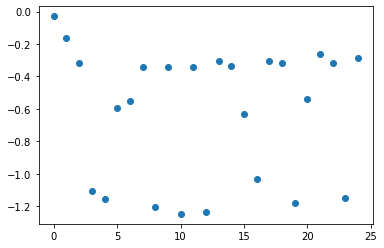

In [232]:
idx = 5230

print(good_data[idx])
print(attention_output[idx])

plt.scatter(np.arange(0, len(attention_output[idx])), attention_output[idx])
plt.show()

In [223]:
attention_output_all = attention_model.predict(data, batch_size=200)
print(attention_output_all.shape)

(20000, 25)


[[0]
 [4]
 [5]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]]
[0.01409244 0.21296704 0.27607703 0.8357383  0.8954886  0.44541532
 0.41425017 0.26083833 0.9454976  0.26196238 0.98535365 0.2603906
 0.9751067  0.23720865 0.25984368 0.4746433  0.7989456  0.23602384
 0.24446326 0.92319536 0.40257055 0.20554723 0.24673556 0.8956383
 0.22132696]


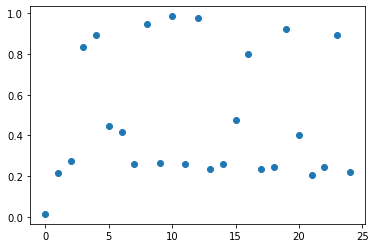

In [235]:
idx = 16549

print(data[idx])
print(attention_output_all[idx])

plt.scatter(np.arange(0, len(attention_output_all[idx])), attention_output_all[idx])
plt.show()

In [ ]:
from tensorflow import keras
from keras.layers import Input, Dense

model = keras.Sequential(
    [
        Input(shape = (21,)),
        Dense(5, name="hidden_layer_1", activation='tanh'),
        Dense(5, name="hidden_layer_2", activation='tanh'),
        Dense(5, name="hidden_layer_3", activation='tanh'),
        Dense(1, name="output_layer"),
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 5)                 110       
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 5)                 30        
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 5)                 30        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(data, target, batch_size=150, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100
107/107 - 0s - loss: 0.2860 - val_loss: 0.3706
Epoch 2/100
107/107 - 0s - loss: 0.2262 - val_loss: 0.3403
Epoch 3/100
107/107 - 0s - loss: 0.1636 - val_loss: 0.2038
Epoch 4/100
107/107 - 0s - loss: 0.1212 - val_loss: 0.1789
Epoch 5/100
107/107 - 0s - loss: 0.1054 - val_loss: 0.1621
Epoch 6/100
107/107 - 0s - loss: 0.0945 - val_loss: 0.1363
Epoch 7/100
107/107 - 0s - loss: 0.0857 - val_loss: 0.1301
Epoch 8/100
107/107 - 0s - loss: 0.0779 - val_loss: 0.1106
Epoch 9/100
107/107 - 0s - loss: 0.0697 - val_loss: 0.0834
Epoch 10/100
107/107 - 0s - loss: 0.0609 - val_loss: 0.0800
Epoch 11/100
107/107 - 0s - loss: 0.0518 - val_loss: 0.0662
Epoch 12/100
107/107 - 0s - loss: 0.0423 - val_loss: 0.0575
Epoch 13/100
107/107 - 0s - loss: 0.0335 - val_loss: 0.0336
Epoch 14/100
107/107 - 0s - loss: 0.0262 - val_loss: 0.0276
Epoch 15/100
107/107 - 0s - loss: 0.0212 - val_loss: 0.0212
Epoch 16/100
107/107 - 0s - loss: 0.0172 - val_loss: 0.0145
Epoch 17/100
107/107 - 0s - loss: 0.0146 - val_lo

## Bonus
```Now implement the attention mechanism the authors suggest as a keras layer. Use the source code of the keras.layers.recurrent class. You can find the paper and the class source code in the current directory.```

```Basic instructions:```
- ```Use your tutor. A lot. This is a hard exercise.```
- ```Open the source code of recurrent neural networks. You would like to implement a layer that inherits from Recurrent.```
- ```Understand the code's flow and the functions you would like to write.```
- ```Start by writing a mechanism that would be a little bit simpler: don't return a sequence, but rather return a single vector.```
- ```Try solving the above problem using your attention mechanism. What problems do you encouter?```
- ```Complete the full mechanism. Assuming Yoshua Bengio didn't lie in his paper, how do you think their architecture overcomes the problem you found?```

In [ ]:
from keras.layers.recurrent import Recurrent


ImportError: cannot import name 'Recurrent' from 'keras.layers.recurrent' (C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\keras\layers\recurrent.py)

In [378]:
BATCH_SIZE = 200
BUFFER_SIZE = 50

dataset = tf.data.Dataset.from_tensor_slices((data, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [379]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [380]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [381]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [382]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [388]:
EPOCHS = 10
steps_per_epoch = len(data)//BATCH_SIZE

encoder = Encoder(vocab_size=7, embedding_dim=16, enc_units=20, batch_sz=BATCH_SIZE)

for epoch in range(EPOCHS):
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: in user code:

    <ipython-input-379-d84b3d8301ef>:14 call  *
        output, state = self.gru(x, initial_state = hidden)
    C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:720 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer gru_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [200, 25, 1, 16]
